# Draw Beams for Hologram Tilt and Shift

- AuxTel

- author : Sylvie Dagoret-Campagne
- affiliation : IJCLab/IN2P3/CNRS

- creation date : May 18th 2020
- update : May 27th 2020
- update March 19th 2021 with Tilt sources plane


In [102]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os
import matplotlib as mpl
import pandas as pd
import itertools
import matplotlib.gridspec as gridspec
from matplotlib.patches import Circle,Ellipse
import matplotlib.colors as colors
import matplotlib.cm as cmx

In [156]:
# to enlarge the sizes
params = {
         'legend.fontsize': 'small',
         'figure.figsize': (13, 13),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large',
         'font.size': 14}
plt.rcParams.update(params)

In [104]:
from scipy.interpolate import interp1d

## Constants for conversions

In [105]:
m_to_mm=1000.
mm_to_m=1e-3
inch_to_mm=25.4
mm_to_inch=1./inch_to_mm
micr_to_m=1e-6
micr_to_mm=1e-3
m_to_micr=1./micr_to_m
m_to_cm=100.
m_to_nm=1e9
nm_to_m=1./m_to_nm

In [106]:
arcdeg_to_arcmin=60.
arcmin_to_arcdeg=1./arcdeg_to_arcmin
arcmin_to_arcsec=60.
arcdeg_to_arcsec=arcdeg_to_arcmin*arcmin_to_arcsec
arcsec_to_arcdeg=1./arcdeg_to_arcsec

In [107]:
deg_to_rad=np.pi/180.

In [108]:
rad_to_deg=1./deg_to_rad
rad_to_arcsec=rad_to_deg*arcdeg_to_arcsec
rad_to_arcmin=rad_to_deg*arcdeg_to_arcmin
arcmin_to_rad=1./rad_to_arcmin

## Configuration parameters at the telescope

#### telescope

In [109]:
Tel_Focal_Length=21.6 # m : Focal length of the telescope
Tel_Diameter=1.2 # m : Diameter of the telescope    
Tel_Fnum=Tel_Focal_Length/Tel_Diameter

#### filter

In [110]:
Filt_D=0.265 # m distance of the filter position wrt CCD plane
Filt_size=3*inch_to_mm

#### CCD detector

In [111]:
Det_xpic=10.0 # microns per pixel
#Det_NbPix=2048 # number of pixels per CCD side
Det_NbPix=4096 # number of pixels per CCD side For 400 only
Det_size=Det_xpic*Det_NbPix*micr_to_mm # CCD size in mm, 5 cm or 2 inch

## Input file

In [112]:
# number of rays
NBEAM_X=11
NBEAM_Y=11
NBEAM=NBEAM_X*NBEAM_Y
NWL=4
NBTOT=NBEAM*NWL

In [113]:
theta_x=0.  # angle in arcmin
theta_y=0.  # angle in arcmin 

In [114]:
theta_x_num=int(theta_x*10)
theta_y_num=int(theta_y*10)

In [115]:
if theta_x_num>0:
    theta_nstr='{:0>2}'.format(theta_x_num)
    theta_x_str="p"+theta_nstr
else:
    theta_nstr='{:0>2}'.format(-theta_x_num)
    theta_x_str="m"+theta_nstr

In [116]:
if theta_y_num>0:
    theta_nstr='{:0>2}'.format(theta_y_num)
    theta_y_str="p"+theta_nstr
else:
    theta_nstr='{:0>2}'.format(-theta_y_num)
    theta_y_str="m"+theta_nstr

In [117]:
Beam4_Rayfile="Beam4_Rayfile_{:d}_allwl_{}_{}".format(NBTOT,theta_x_str,theta_y_str)

In [118]:
Beam4_Rayfile

'Beam4_Rayfile_484_allwl_m00_m00'

# Read input files

In [119]:
def GetBeamParam(df):
    X0C=df["X0"].mean()
    Y0C=df["Y0"].mean()
    RXMAX=np.max(np.abs(df["X0"].values-X0C))
    RYMAX=np.max(np.abs(df["Y0"].values-Y0C))   
    RMAX=np.max(np.array([RXMAX,RYMAX]))
    return X0C,Y0C,RMAX

In [120]:
def Select_Beam(row):
    return (row["X0"]-X0C)**2+(row["Y0"]-Y0C)**2 <= RMAX**2

## Input files

In [142]:
rayfile_hoe="HOE_"+Beam4_Rayfile+"_RAY_OUT.xlsx"
rayfile_R150="R150_"+Beam4_Rayfile+"_RAY_OUT.xlsx"
all_reffilenames = [rayfile_hoe,rayfile_R150]

In [121]:
all_filenames=[]
for idx in np.arange(10):
    filename="HOETILTshift{}mm_Beam4_Rayfile_484_allwl_m00_m00_OUT_RAY.xlsx".format(idx)
    all_filenames.append(filename)
NF=len(all_filenames)    

In [122]:
jet = plt.get_cmap('jet')
cNorm = colors.Normalize(vmin=0, vmax=NF)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
all_colors = scalarMap.to_rgba(np.arange(NF), alpha=1)

In [123]:
def stripSquareBeam(df,disperser_name,plot_flag=True):
    """
    stripSquareBeam(df,disperser_name,plot_flag=True)
    
    Cut the square beam into a found circle
    
    
    """   
    
    df_filter=df.copy()
    df_filter=df_filter.loc[df_filter.apply(Select_Beam, axis=1)]
    df_filter=df_filter.reset_index()   # reset index
    df=df_filter.copy()
    
    X0=np.array(df_filter["X0"].values,dtype='float64')
    Y0=np.array(df_filter["Y0"].values,dtype='float64')
    V0=np.array(df_filter["V0"].values,dtype='float64')
    U0=np.array(df_filter["U0"].values,dtype='float64')
    
    if plot_flag:
        f, ((ax1, ax2)) = plt.subplots(1, 2,figsize=(18,9),sharex=True,sharey=True)
        df_filter.plot.scatter(x="X0", y="Y0",c="DarkBlue",marker="o",ax=ax1)
        ax1.set_aspect("equal")
        ax1.grid()

        q = ax2.quiver(X0,Y0, U0,V0,color="red")
        ax2.set_aspect("equal")
        ax2.set_xlabel("X0 (mm)")
        ax2.grid()

        title = disperser_name + " :Filtered circular beam"
        plt.suptitle(title)
        
    return df
    

## Read rays files

### Ronchi and disperser HOE not tilt

In [145]:
all_dfref = []
for ifile in np.arange(2):
    filename = all_reffilenames[ifile]
    inputf = pd.ExcelFile(filename)
    df=inputf.parse(index_row=0,header=1)
    df=df.drop(0)
    df=df.reset_index()
    df.columns = ["index","X0","Y0","Z0","U0","V0","W0","wave","col","X1","Y1","Z1","X2","Y2","Z2","X3","Y3","Z3","Xgoal","Ygoal","Xfinal","Yfinal","Zfinal","Notes","Unnamed"]
    X0C,Y0C,RMAX=GetBeamParam(df)
    dispname="REF{}".format(ifile)
    df=stripSquareBeam(df,dispname,plot_flag=False)
    all_dfref.append(df)

### Tilt and shift

In [124]:
all_df = []
for ifile in np.arange(NF):
    filename=all_filenames[ifile]
    inputf = pd.ExcelFile(filename)
    df=inputf.parse(index_row=0,header=1)
    df=df.drop(0)
    df=df.reset_index()
    df.columns = ["index","X0","Y0","Z0","U0","V0","W0","wave","col","X1","Y1","Z1","X2","Y2","Z2","X3","Y3","Z3","Xgoal","Ygoal","Xfinal","Yfinal","Zfinal","Notes","Unnamed"]
    X0C,Y0C,RMAX=GetBeamParam(df)
    hoename="HOE{}".format(ifile)
    df=stripSquareBeam(df,hoename,plot_flag=False)
    all_df.append(df)

# Draw beam

Now we want to draw the profile of the beam

In [125]:
ColorDict = {0.0004:"b",0.0006:"g",0.0008:"r",0.001:"k"}  # map wl --> color character
WLIndexDict = {0:0.0004,1:0.0006,2:0.0008,3:0.001}        # map index --> wl in mm
ColorNum = ["b","g","r","k"]
WLARRAY = np.array([0.0004,0.0006,0.0008,0.001])

## Definition of the functions to be used

In [126]:
def GetRayConvergence(x0,y0,u0,v0,y1,u1,v1,y2,u2,v2,wl,a,m=1,XMIN=0,XMAX=100,YMIN=0,YMAX=100):
    """
    Compute convergence of upper, lower and central ray in 2D plane (X,Y)
    input:
      (x0,y0) : coordinate of central ray usually (0,0)
      (u0,v0) : vector director coordinate of central ray (usually  (1,0) )
      (u1,v1) : vector director coordinate of upper ray (usually  u1>0 v1<0)
      (u2,v2) : vector director coordinate of lower ray (usually  u2>0 v2<0)
      (x0,y1) : upper ray coordinate at disperser   y1>0
      (x0,y2) : lower ray coordinate at disperser  usually y2=-y1 <0
      a : grating spacing in mm
      wl : wavelength in mm
      m : order
      all units are in mm
    
    """
    #assert u0**2+v0**2==1
    #assert u1**2+v1**2==1
    #assert u2**2+v2**2==1
    
    # angles with respect to horizontal line
    theta0=np.arcsin(v0+m*wl/a)
    theta1=np.arcsin(v1+m*wl/a)
    theta2=np.arcsin(v2+m*wl/a)
    
    XX=np.linspace(XMIN,XMAX,50)
    
    YY0=y0+np.tan(theta0)*(XX-x0)
    YY1=y1+np.tan(theta1)*(XX-x0)
    YY2=y2+np.tan(theta2)*(XX-x0)
    
    return XX,YY0,YY1,YY2
    

In [127]:
def GetRayConvergenceIntersectionSimple(x0,y0,u0,v0,y1,u1,v1,y2,u2,v2,wl,a,m=1):
    """
    Compute convergence intersection of upper, lower and central ray in 2D plane (X,Y)
    input:
      (x0,y0) : coordinate of central ray usually (0,0)
      (u0,v0) : vector director coordinate of central ray (usually  (1,0) )
      (u1,v1) : vector director coordinate of upper ray (usually  u1>0 v1<0)
      (u2,v2) : vector director coordinate of lower ray (usually  u2>0 v2<0)
      (x0,y1) : upper ray coordinate at disperser   y1>0
      (x0,y2) : lower ray coordinate at disperser  usually y2=-y1 <0
      a : grating spacing in mm
      wl : wavelength in mm
      m : order
      all units are in mm
    
    """
    #assert u0**2+v0**2==1
    #assert u1**2+v1**2==1
    #assert u2**2+v2**2==1
    
    # angles with respect to horizontal line
    theta0=np.arcsin(v0+m*wl/a)
    theta1=np.arcsin(v1+m*wl/a)
    theta2=np.arcsin(v2+m*wl/a)
    

    dx=(y1-y2)/(np.tan(theta2)-np.tan(theta1))
    x=x0+dx
    y=y0+np.tan(theta0)*dx
    
    
    return x,y
    

In [128]:
def GetRayConvergenceIntersectionPoints(x0,y0,u0,v0,y1,u1,v1,y2,u2,v2,a,m=1,WLMIN=0.,WLMAX=1200.,NBPOINTS=1200):
    """
    Give the convergence points
    
    """
    
    
    all_wl=np.linspace(WLMIN,WLMAX,NBPOINTS)*1e-6
    
    X,Y=GetRayConvergenceIntersectionSimple(x0,y0,u0,v0,y1,u1,v1,y2,u2,v2,all_wl,a,m)
       
    return X,Y

In [129]:
def GetRayConvergenceIntersectionPoints2(x0,y0,u0,v0,y1,u1,v1,y2,u2,v2,a,m=1,WLMIN=0.,WLMAX=1000.,NBPOINTS=1000):
    """
    Give the predicted convergence curve predicted for a grating.
    It is not the true ray convergence (example bad for hologram)
    
    """
    all_wl=np.linspace(WLMIN,WLMAX,NBPOINTS)*1e-6
    
    X,Y=GetRayConvergenceIntersectionSimple(x0,y0,u0,v0,y1,u1,v1,y2,u2,v2,all_wl,a,m)
       
    return X,Y,all_wl

In [130]:
def GetRayConvergenceIntersectionPointsCanonic(x0,y0,u0,v0,y1,u1,v1,y2,u2,v2,a,m=1):
    """
    Give the convergence points at 0.4, 0.6, 0.8, 1.0
    
    """
      
    all_wl=np.array([400.,600.,800.,1000.])*1e-6
    
    X,Y=GetRayConvergenceIntersectionSimple(x0,y0,u0,v0,y1,u1,v1,y2,u2,v2,all_wl,a,m)
       
    return X,Y

In [131]:
def GetCentralRay(df):
    """
    """
    central_ray=df.loc[(df["U0"]==0) & (df["X0"]==0) & (df["Y0"]==0)]
    return central_ray

In [132]:
def GetUpperRay(df):
    """
    """
    upper_ray=df.loc[(df["X0"]==df["X0"].max()) & (df["Y0"]==0)]
    return upper_ray

In [133]:
def GetLowerRay(df):
    """
    """
    lower_ray=df.loc[(df["X0"]==df["X0"].min()) & (df["Y0"]==0)]
    return lower_ray

In [134]:
def GetScatteredBeamConvergence(df):
    """
    Get the convergence for each wavelength calculated from scattered rays
    
    input
       df : Beam Dataframe
    output :
       arrays of (X,Y) convergence position for each wavelength 
    """
    
    # extract the three main rays of the beam
    central_ray=GetCentralRay(df)
    upper_ray=GetUpperRay(df)
    lower_ray=GetLowerRay(df)
    
    # extract coordinates of scattered beams
    xc_1=central_ray["Z2"].values
    yc_1=central_ray["X2"].values
    
    xc_2=central_ray["Z3"].values
    yc_2=central_ray["X3"].values
    
    
   
    xup_1=upper_ray["Z2"].values
    yup_1=upper_ray["X2"].values
    
    xup_2=upper_ray["Z3"].values
    yup_2=upper_ray["X3"].values
    
    aup=(yup_2-yup_1)/(xup_2-xup_1)  # slope of upper ray 
    
    
    xlo_1=lower_ray["Z2"].values
    ylo_1=lower_ray["X2"].values
    
    xlo_2=lower_ray["Z3"].values
    ylo_2=lower_ray["X3"].values
    
    alo=(ylo_2-ylo_1)/(xlo_2-xlo_1)  # slope of upper ray 
    
    # compute intersection of scattered upper and lower ray
    
    da=aup-alo   # difference of slopes
    
    x_I= -(yup_1-ylo_1)/da + (aup*xup_1 -alo*xlo_1)/da
    y_I=aup*(x_I-xup_1)+yup_1
    
    return x_I,y_I

# Analysis

In [146]:
all_XI_ref=[]
all_YI_ref=[]
Zshift=0
all_Focusfunc_ref = []
for df in all_dfref :
    Zshift=0
    for index, row in df.iterrows():
        wl=row["wave"]
        #col=ColorDict[wl]
        X0=row["X0"];Y0=row["Y0"];Z0=row["Z0"]-row["Z3"]
        X1=row["X1"];Y1=row["Y1"];Z1=row["Z1"]-row["Z3"]
        X2=row["X2"];Y2=row["Y2"];Z2=row["Z2"]-row["Z3"]
        X3=row["X3"];Y3=row["Y3"];Z3=row["Z3"]-row["Z3"]
        Zshift=row["Z3"]
    
    XI,YI=GetScatteredBeamConvergence(df)
    XIshift=np.array(XI)-Zshift
    all_XI_ref.append(XIshift)  
    all_YI_ref.append(YI)
    
    Xspline=WLARRAY*1e6
    Yspline=XIshift
    focusfunc = interp1d(Xspline,Yspline, kind='cubic')
    all_Focusfunc_ref.append(focusfunc)

In [136]:
all_XI=[]
all_YI=[]
Zshift=0
all_Focusfunc = []
for df in all_df :
    Zshift=0
    for index, row in df.iterrows():
        wl=row["wave"]
        #col=ColorDict[wl]
        X0=row["X0"];Y0=row["Y0"];Z0=row["Z0"]-row["Z3"]
        X1=row["X1"];Y1=row["Y1"];Z1=row["Z1"]-row["Z3"]
        X2=row["X2"];Y2=row["Y2"];Z2=row["Z2"]-row["Z3"]
        X3=row["X3"];Y3=row["Y3"];Z3=row["Z3"]-row["Z3"]
        Zshift=row["Z3"]
    
    XI,YI=GetScatteredBeamConvergence(df)
    XIshift=np.array(XI)-Zshift
    all_XI.append(XIshift)  
    all_YI.append(YI)
    
    Xspline=WLARRAY*1e6
    Yspline=XIshift
    focusfunc = interp1d(Xspline,Yspline, kind='cubic')
    all_Focusfunc.append(focusfunc)

In [137]:
Xspline=WLARRAY*1e6
Xfoc=np.linspace(Xspline[0],Xspline[-1],100)

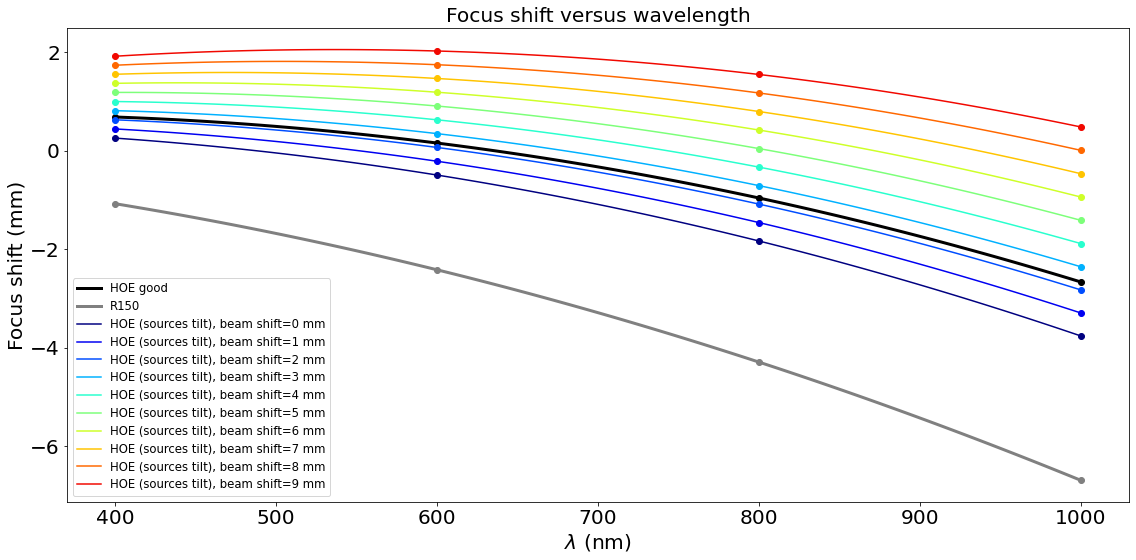

In [160]:
plt.figure(figsize=(16,8))

plt.plot(WLARRAY*1e6,all_XI_ref[0],"o",color='k',lw=3)
plt.plot(Xfoc,all_Focusfunc_ref[0](Xfoc),'-',color='k',lw=3,label='HOE good')
plt.plot(WLARRAY*1e6,all_XI_ref[1],"o",color='grey',lw=3)
plt.plot(Xfoc,all_Focusfunc_ref[1](Xfoc),'-',color='grey',lw=3,label='R150')

for idx in np.arange(NF):
    plt.plot(WLARRAY*1e6,all_XI[idx],"o",color=all_colors[idx])
    label="HOE (sources tilt), beam shift={} mm".format(idx)
    plt.plot(Xfoc,all_Focusfunc[idx](Xfoc),'-',color=all_colors[idx],label=label)
    
plt.legend()
plt.xlabel("$\\lambda$ (nm)")
plt.ylabel("Focus shift (mm)")
plt.title("Focus shift versus wavelength")
plt.tight_layout()
plt.savefig("FocusShiftAuxTel_2021.pdf")

In [139]:
all_XI

[array([0.25650299685418076, -0.49329745407027303, -1.831464521252542,
        -3.7585360355163857], dtype=object),
 array([0.4423978341956172, -0.21309887321427823, -1.4576915167509696,
        -3.2919747902149084], dtype=object),
 array([0.6282775299812897, 0.06699111888957532, -1.0828548344432534,
        -2.823878158537241], dtype=object),
 array([0.8135965330594104, 0.34751021081353883, -0.7076654175969566,
        -2.354240118428663], dtype=object),
 array([0.9990780913035451, 0.6277340467430577, -0.3319479327818158,
        -1.8834078869079462], dtype=object),
 array([1.1839934624106832, 0.9076567959687623, 0.044115424880772025,
        -1.4113804780339478], dtype=object),
 array([1.3685210554313016, 1.1878191390129018, 0.42052048667233066,
        -0.9386919226799364], dtype=object),
 array([1.5524749352011895, 1.4671236571878694, 0.7965371700634591,
        -0.4651698008310632], dtype=object),
 array([1.7360341797356114, 1.7461094598552904, 1.172699460752142,
        0.0088215

In [140]:
alert False

SyntaxError: invalid syntax (<ipython-input-140-0039b9705ac8>, line 1)

In [ ]:
# gridspec inside gridspec
fig = plt.figure(figsize=(16,14))
gs0 = gridspec.GridSpec(2, 1, figure=fig)

################
# Top figure
################

ax1 = fig.add_subplot(gs0[0])

## get the focalisation 
a      = 1./150.   # the grating
idx_wl = 3    # choose one of the wavelength
thewl  = WLIndexDict[idx_wl] 

df=all_df[0]

# main rays
central_ray_wl=GetCentralRay(df).iloc[idx_wl]
upper_ray_wl=GetUpperRay(df).iloc[idx_wl]
lower_ray_wl=GetLowerRay(df).iloc[idx_wl]
x0=0
y0=central_ray_wl["X0"]
u0=central_ray_wl["W0"]
v0=central_ray_wl["U0"]

y1=upper_ray_wl["X2"]
u1=upper_ray_wl["W0"]
v1=upper_ray_wl["U0"]

y2=lower_ray_wl["X2"]
u2=lower_ray_wl["W0"]
v2=lower_ray_wl["U0"]
XXXR150,YYYR150=GetRayConvergenceIntersectionPoints(x0,y0,u0,v0,y1,u1,v1,y2,u2,v2,a,m=1,WLMIN=0.,WLMAX=1500.,NBPOINTS=500)
XXXR150=XXXR150+central_ray_wl["Z2"]-central_ray_wl["Z3"]

for index, row in df_R150.iterrows():
    wl=row["wave"]
    col=ColorDict[wl]
    X0=row["X0"];Y0=row["Y0"];Z0=row["Z0"]-row["Z3"]
    X1=row["X1"];Y1=row["Y1"];Z1=row["Z1"]-row["Z3"]
    X2=row["X2"];Y2=row["Y2"];Z2=row["Z2"]-row["Z3"]
    X3=row["X3"];Y3=row["Y3"];Z3=row["Z3"]-row["Z3"]
    if Y0==0:
        ax1.plot([Z0,Z1],[X0,X1],"-",color=col)
        ax1.plot([Z1,Z2],[X1,X2],"-",color=col)
        ax1.plot([Z2,Z3],[X2,X3],"-",color=col)
        
#ellipse = mpl.patches.Ellipse(xy=(X0C_R400, Y0C_R400), width=2*R0C_R400, height=2*R0C_R400,angle=1,color="grey",fill=False)        
#fig.gca().add_artist(ellipse)
ax1.plot(XXXR150,YYYR150,"--",color="grey",lw=2) # plot trajectory curve

ax1.grid()
ax1.set_xlim(-220,0)
ax1.set_ylim(-10,40)
ax1.set_aspect('equal')
ax1.set_xlabel("Z (mm)")
ax1.set_ylabel("X (mm)")
ax1.set_title("Dispersion of beam (Ronchi 150)",fontweight="bold",fontsize=24)
ax1.tick_params(axis='both', which='major', labelsize=20)
#ax1.tick_params(axis='both', which='minor', labelsize=8)

###################
# Bottom figures
#################

gs01 = gs0[1].subgridspec(1, 2)
ax2=fig.add_subplot(gs01[0,0])
ax3=fig.add_subplot(gs01[0,1])


#################################
# Bottom left figure with RON150
#################################


#shifts_R150=[-1.1,-2.4,-4.3,-6.7]

## get the focalisation points
a      = 1./150.   # the grating
idx_wl = 3    # choose one of the wavelength
thewl  = WLIndexDict[idx_wl] 

# main rays
central_ray_wl=GetCentralRay(df_R150).iloc[idx_wl]
upper_ray_wl=GetUpperRay(df_R150).iloc[idx_wl]
lower_ray_wl=GetLowerRay(df_R150).iloc[idx_wl]

x0=0
y0=central_ray_wl["X0"]
u0=central_ray_wl["W0"]
v0=central_ray_wl["U0"]

y1=upper_ray_wl["X2"]
u1=upper_ray_wl["W0"]
v1=upper_ray_wl["U0"]

y2=lower_ray_wl["X2"]
u2=lower_ray_wl["W0"]
v2=lower_ray_wl["U0"]
XXXR150,YYYR150=GetRayConvergenceIntersectionPoints(x0,y0,u0,v0,y1,u1,v1,y2,u2,v2,a,m=1,WLMIN=0.,WLMAX=1500.,NBPOINTS=500)
XXXR150=XXXR150+central_ray_wl["Z2"]-central_ray_wl["Z3"]
    
Zshift=0    
for index, row in df_R150.iterrows():
    wl=row["wave"]
    col=ColorDict[wl]
    X0=row["X0"];Y0=row["Y0"];Z0=row["Z0"]-row["Z3"]
    X1=row["X1"];Y1=row["Y1"];Z1=row["Z1"]-row["Z3"]
    X2=row["X2"];Y2=row["Y2"];Z2=row["Z2"]-row["Z3"]
    X3=row["X3"];Y3=row["Y3"];Z3=row["Z3"]-row["Z3"]
    Zshift=row["Z3"]
    if Y0==0:
        ax2.plot([Z2,Z3],[X2,X3],"-",color=col)
            
    #ellipse = mpl.patches.Ellipse(xy=(X0C_R350, Y0C_R350), width=2*R0C_R350, height=2*R0C_R350,angle=1,color="grey",fill=False)        
    #fig.gca().add_artist(ellipse)
    #ax3.add_artist(ellipse)
    
ax2.plot(XXXR150,YYYR150,"--",color="grey",lw=2) # plot trajectory curve

# vertical lines marking defocus
#for shift in shifts_R150:
#    ax2.axvline(x=shift,color="orange",lw=1)
XI,YI=GetScatteredBeamConvergence(df_R150)
XI=XI-Zshift
for idx in np.arange(len(XI)):
        ax2.scatter([XI[idx]],[YI[idx]],marker="+",color=ColorNum[idx],s=1500,lw=1)
    
ax2.grid()
ax2.set_xlim(-20,0)
ax2.set_ylim(10,35)
ax2.set_xlabel("Z (mm)")
ax2.set_ylabel("X (mm)")
ax2.set_aspect('equal')
ax2.set_title("Ronchi 150",fontweight="bold",fontsize=22)
ax2.tick_params(axis='both', which='major', labelsize=20)
#ax1.tick_params(axis='both', which='minor', labelsize=8)


###########################
# Bottom right figure : HOE
#############################  
    
#shifts_HOE=[0.7,0.2,-1.0,-2.7]
     
Zshift=0
for index, row in df_hoe.iterrows():
    wl=row["wave"]
    col=ColorDict[wl]
    X0=row["X0"];Y0=row["Y0"];Z0=row["Z0"]-row["Z3"]
    X1=row["X1"];Y1=row["Y1"];Z1=row["Z1"]-row["Z3"]
    X2=row["X2"];Y2=row["Y2"];Z2=row["Z2"]-row["Z3"]
    X3=row["X3"];Y3=row["Y3"];Z3=row["Z3"]-row["Z3"]
    Zshift=row["Z3"]
    if Y0==0:
        ax3.plot([Z2,Z3],[X2,X3],"-",color=col)
            
            
    #ellipse = mpl.patches.Ellipse(xy=(X0C_R400, Y0C_R400), width=2*R0C_R400, height=2*R0C_R400,angle=1,color="grey",fill=False)        
    #ax4.add_artist(ellipse)

#ax3.plot(XXXR150,YYYR150,"--",color="grey",lw=2) # plot trajectory curve

    
# vertical lines marking defocus
#for shift in shifts_HOE:
#    ax3.axvline(x=shift,color="orange",lw=1)
XI,YI=GetScatteredBeamConvergence(df_hoe)
XI=XI-Zshift
for idx in np.arange(len(XI)):
        ax3.scatter([XI[idx]],[YI[idx]],marker="+",color=ColorNum[idx],s=1500,lw=1)


ax3.grid()
ax3.set_xlim(-20,0)
ax3.set_ylim(10,35)
ax3.set_xlabel("Z (mm)")
ax3.set_ylabel("X (mm)")
ax3.set_aspect('equal')
ax3.set_title("Hologram",fontweight="bold",fontsize=22)
ax3.tick_params(axis='both', which='major', labelsize=20)
    #ax1.tick_params(axis='both', which='minor', labelsize=8)

plt.tight_layout()
plt.subplots_adjust(wspace=0.1,hspace=0.05)
plt.savefig("Beam4BeamDispersionAuxTel.pdf")



### 2021 plot with titled hologram

In [ ]:
# gridspec inside gridspec
fig = plt.figure(figsize=(16,10))

gs0 = gridspec.GridSpec(2, 1, figure=fig)

################
# Top figure
################

ax1 = fig.add_subplot(gs0[0])

## get the focalisation 
a      = 1./150.   # the grating
idx_wl = 3    # choose one of the wavelength
thewl  = WLIndexDict[idx_wl] 

# main rays
central_ray_wl=GetCentralRay(df_hoe).iloc[idx_wl]
upper_ray_wl=GetUpperRay(df_hoe).iloc[idx_wl]
lower_ray_wl=GetLowerRay(df_hoe).iloc[idx_wl]
x0=0
y0=central_ray_wl["X0"]
u0=central_ray_wl["W0"]
v0=central_ray_wl["U0"]

y1=upper_ray_wl["X2"]
u1=upper_ray_wl["W0"]
v1=upper_ray_wl["U0"]

y2=lower_ray_wl["X2"]
u2=lower_ray_wl["W0"]
v2=lower_ray_wl["U0"]
XXXHOE,YYYHOE=GetRayConvergenceIntersectionPoints(x0,y0,u0,v0,y1,u1,v1,y2,u2,v2,a,m=1,WLMIN=0.,WLMAX=1500.,NBPOINTS=500)
XXXHOE=XXXHOE+central_ray_wl["Z2"]-central_ray_wl["Z3"]

for index, row in df_hoe.iterrows():
    wl=row["wave"]
    col=ColorDict[wl]
    X0=row["X0"];Y0=row["Y0"];Z0=row["Z0"]-row["Z3"]
    X1=row["X1"];Y1=row["Y1"];Z1=row["Z1"]-row["Z3"]
    X2=row["X2"];Y2=row["Y2"];Z2=row["Z2"]-row["Z3"]
    X3=row["X3"];Y3=row["Y3"];Z3=row["Z3"]-row["Z3"]
    if Y0==0:
        ax1.plot([Z0,Z1],[X0,X1],"-",color=col)
        ax1.plot([Z1,Z2],[X1,X2],"-",color=col)
        ax1.plot([Z2,Z3],[X2,X3],"-",color=col)
        

XI,YI=GetScatteredBeamConvergence(df_hoe)
XI=XI-Zshift
for idx in np.arange(len(XI)):
        ax1.scatter([XI[idx]],[YI[idx]],marker="+",color=ColorNum[idx],s=1500,lw=1)

ax1.grid()
ax1.set_xlim(-220,0)
ax1.set_ylim(-10,40)
ax1.set_aspect('equal')
ax1.set_xlabel("Z (mm)")
ax1.set_ylabel("X (mm)")
ax1.set_title("Dispersion of beam for HOE",fontweight="bold",fontsize=24)
ax1.tick_params(axis='both', which='major', labelsize=10)


###################
# Bottom figures
#################

gs01 = gs0[1].subgridspec(1, 4)
ax2=fig.add_subplot(gs01[0,0])
ax3=fig.add_subplot(gs01[0,1])
ax4=fig.add_subplot(gs01[0,2])
ax5=fig.add_subplot(gs01[0,3])

#################################
# Bottom left figure with HOE
#################################

idx_wl = 3    # choose one of the wavelength
thewl  = WLIndexDict[idx_wl] 

# main rays
central_ray_wl=GetCentralRay(df_hoe).iloc[idx_wl]
upper_ray_wl=GetUpperRay(df_hoe).iloc[idx_wl]
lower_ray_wl=GetLowerRay(df_hoe).iloc[idx_wl]

x0=0
y0=central_ray_wl["X0"]
u0=central_ray_wl["W0"]
v0=central_ray_wl["U0"]

y1=upper_ray_wl["X2"]
u1=upper_ray_wl["W0"]
v1=upper_ray_wl["U0"]

y2=lower_ray_wl["X2"]
u2=lower_ray_wl["W0"]
v2=lower_ray_wl["U0"]
XXXHOE,YYYHOE=GetRayConvergenceIntersectionPoints(x0,y0,u0,v0,y1,u1,v1,y2,u2,v2,a,m=1,WLMIN=0.,WLMAX=1500.,NBPOINTS=500)
XXXHOE=XXXHOE+central_ray_wl["Z2"]-central_ray_wl["Z3"]
    
Zshift=0    
for index, row in df_hoe.iterrows():
    wl=row["wave"]
    col=ColorDict[wl]
    X0=row["X0"];Y0=row["Y0"];Z0=row["Z0"]-row["Z3"]
    X1=row["X1"];Y1=row["Y1"];Z1=row["Z1"]-row["Z3"]
    X2=row["X2"];Y2=row["Y2"];Z2=row["Z2"]-row["Z3"]
    X3=row["X3"];Y3=row["Y3"];Z3=row["Z3"]-row["Z3"]
    Zshift=row["Z3"]
    if Y0==0:
        ax2.plot([Z2,Z3],[X2,X3],"-",color=col)
            
XI,YI=GetScatteredBeamConvergence(df_hoe)
XI=XI-Zshift
for idx in np.arange(len(XI)):
        ax2.scatter([XI[idx]],[YI[idx]],marker="+",color=ColorNum[idx],s=1500,lw=1)

              
ax2.grid()
ax2.set_xlim(-20,0)
ax2.set_ylim(10,35)
ax2.set_xlabel("Z (mm)")
ax2.set_ylabel("X (mm)")
ax2.set_aspect('equal')
ax2.set_title("HOE",fontweight="bold",fontsize=10)
ax2.tick_params(axis='both', which='major', labelsize=10)


Xspline=WLARRAY*1e6
Yspline=XI
focusHOE = interp1d(Xspline,Yspline, kind='cubic')
XI_HOE=XI

###########################
# Bottom figure : HOE TILT
#############################  
    
Zshift=0
for index, row in df_hoetilt.iterrows():
    wl=row["wave"]
    col=ColorDict[wl]
    X0=row["X0"];Y0=row["Y0"];Z0=row["Z0"]-row["Z3"]
    X1=row["X1"];Y1=row["Y1"];Z1=row["Z1"]-row["Z3"]
    X2=row["X2"];Y2=row["Y2"];Z2=row["Z2"]-row["Z3"]
    X3=row["X3"];Y3=row["Y3"];Z3=row["Z3"]-row["Z3"]
    Zshift=row["Z3"]
    if Y0==0:
        ax3.plot([Z2,Z3],[X2,X3],"-",color=col)
            
            
XI,YI=GetScatteredBeamConvergence(df_hoetilt)
XI=XI-Zshift
for idx in np.arange(len(XI)):
        ax3.scatter([XI[idx]],[YI[idx]],marker="+",color=ColorNum[idx],s=1500,lw=1)

ax3.grid()
ax3.set_xlim(-20,0)
ax3.set_ylim(10,35)
ax3.set_xlabel("Z (mm)")
ax3.set_ylabel("X (mm)")
ax3.set_aspect('equal')
ax3.set_title("HOE with tilted sources",fontweight="bold",fontsize=10)
ax3.tick_params(axis='both', which='major', labelsize=10)
   
Xspline=WLARRAY*1e6
Yspline=XI
focusHOETILT = interp1d(Xspline,Yspline, kind='cubic')
XI_HOETILT=XI    
    
   
###########################
# Bottom figure : HOE TILT Sim2
#############################  
    
Zshift=0
for index, row in df_hoetiltsim2.iterrows():
    wl=row["wave"]
    col=ColorDict[wl]
    X0=row["X0"];Y0=row["Y0"];Z0=row["Z0"]-row["Z3"]
    X1=row["X1"];Y1=row["Y1"];Z1=row["Z1"]-row["Z3"]
    X2=row["X2"];Y2=row["Y2"];Z2=row["Z2"]-row["Z3"]
    X3=row["X3"];Y3=row["Y3"];Z3=row["Z3"]-row["Z3"]
    Zshift=row["Z3"]
    if Y0==0:
        ax4.plot([Z2,Z3],[X2,X3],"-",color=col)
            
            
XI,YI=GetScatteredBeamConvergence(df_hoetiltsim2)
XI=XI-Zshift
for idx in np.arange(len(XI)):
        ax4.scatter([XI[idx]],[YI[idx]],marker="+",color=ColorNum[idx],s=1500,lw=1)

ax4.grid()
ax4.set_xlim(-20,0)
ax4.set_ylim(10,35)
ax4.set_xlabel("Z (mm)")
ax4.set_ylabel("X (mm)")
ax4.set_aspect('equal')
ax4.set_title("HOE with tilted sources sim2",fontweight="bold",fontsize=10)
ax4.tick_params(axis='both', which='major', labelsize=10)
   
Xspline=WLARRAY*1e6
Yspline=XI
focusHOETILTSIM2 = interp1d(Xspline,Yspline, kind='cubic')
XI_HOETILT2=XI    
    

###########################
# Bottom figure : HOE TILT Sim3
#############################  
    
Zshift=0
for index, row in df_hoetiltsim3.iterrows():
    wl=row["wave"]
    col=ColorDict[wl]
    X0=row["X0"];Y0=row["Y0"];Z0=row["Z0"]-row["Z3"]
    X1=row["X1"];Y1=row["Y1"];Z1=row["Z1"]-row["Z3"]
    X2=row["X2"];Y2=row["Y2"];Z2=row["Z2"]-row["Z3"]
    X3=row["X3"];Y3=row["Y3"];Z3=row["Z3"]-row["Z3"]
    Zshift=row["Z3"]
    if Y0==0:
        ax5.plot([Z2,Z3],[X2,X3],"-",color=col)
            
            
XI,YI=GetScatteredBeamConvergence(df_hoetiltsim3)
XI=XI-Zshift
for idx in np.arange(len(XI)):
        ax5.scatter([XI[idx]],[YI[idx]],marker="+",color=ColorNum[idx],s=1500,lw=1)

ax5.grid()
ax5.set_xlim(-20,0)
ax5.set_ylim(10,35)
ax5.set_xlabel("Z (mm)")
ax5.set_ylabel("X (mm)")
ax5.set_aspect('equal')
ax5.set_title("HOE with tilted sources sim3",fontweight="bold",fontsize=10)
ax5.tick_params(axis='both', which='major', labelsize=10)
   
Xspline=WLARRAY*1e6
Yspline=XI
focusHOETILTSIM3 = interp1d(Xspline,Yspline, kind='cubic')
XI_HOETILT3=XI      
    



plt.tight_layout()
plt.subplots_adjust(wspace=0.1,hspace=0.05)
plt.savefig("Beam4BeamDispersionAuxTel_2021.pdf")




# Draw defocus vs wavelength

In [ ]:
def find_nearest_idx(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

In [ ]:
## get the focalisation 
a      = 1./150.   # the grating
idx_wl = 3    # choose one of the wavelength
thewl  = WLIndexDict[idx_wl] 

# main rays
central_ray_wl=GetCentralRay(df_R150).iloc[idx_wl]
upper_ray_wl=GetUpperRay(df_R150).iloc[idx_wl]
lower_ray_wl=GetLowerRay(df_R150).iloc[idx_wl]
x0=0
y0=central_ray_wl["X0"]
u0=central_ray_wl["W0"]
v0=central_ray_wl["U0"]

y1=upper_ray_wl["X2"]
u1=upper_ray_wl["W0"]
v1=upper_ray_wl["U0"]

y2=lower_ray_wl["X2"]
u2=lower_ray_wl["W0"]
v2=lower_ray_wl["U0"]


XXXR150,YYYR150,WLR150=GetRayConvergenceIntersectionPoints2(x0,y0,u0,v0,y1,u1,v1,y2,u2,v2,a,m=1,WLMIN=0.,WLMAX=1100.,NBPOINTS=1100)
XXXR150=XXXR150+central_ray_wl["Z2"]-central_ray_wl["Z3"]


In [ ]:
Xspline=WLARRAY*1e6

In [ ]:
Xfoc=np.linspace(Xspline[0],Xspline[-1],100)

In [ ]:
Yfoc=focusHOE(Xfoc)

In [ ]:
Yfoc1=focusHOETILT(Xfoc)

In [ ]:
plt.figure(figsize=(16,8))
plt.plot(WLR150*1e6,XXXR150,"b",label="Ronchi 150")
plt.plot(WLARRAY*1e6,XI_HOE,"or")
plt.plot(WLARRAY*1e6,XI_HOETILT,"og")
plt.plot(WLARRAY*1e6,XI_HOETILT2,"o",color="orange")
plt.plot(WLARRAY*1e6,XI_HOETILT3,"o",color="cyan")
plt.plot(Xfoc,Yfoc,"r--",label="Hologram")
plt.plot(Xfoc,Yfoc1,"g--",label="Hologram with tilt sources")
plt.grid()
plt.legend()
plt.xlabel("$\\lambda$ (nm)")
plt.ylabel("Focus shift (mm)")
plt.title("Focus shift versus wavelength")
plt.tight_layout()
plt.savefig("FocusShiftAuxTel_2021.pdf")

In [ ]:
idx_R150=find_nearest_idx(WLR150*1e6,750)

In [ ]:
XXXR150[idx_R150]

In [ ]:
idx_R150=find_nearest_idx(WLR150*1e6,1000)

In [ ]:
XXXR150[idx_R150]

In [ ]:
idx_HOE=find_nearest_idx(Xfoc,750)

In [ ]:
idx_HOE

In [ ]:
Yfoc[idx_HOE]

In [ ]:
idx_HOE=find_nearest_idx(Xfoc,1000)

In [ ]:
Yfoc[idx_HOE]